In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reading the data
co_data = pd.read_csv("/home/deepak/4th semester/ML/Project/dataset/crude-oil-price.csv", parse_dates=['date'])
# Renaming the columns for model prediction with prophet
co_data = co_data.rename(columns={'date': 'ds', 'price': 'y'})

# Convert the dataframe to a suitable format for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(co_data['y'].values.reshape(-1, 1))

# Define sequence length and split data into sequences
sequence_length = 12  # Example sequence length
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training, validation, and test sets
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

2024-05-04 21:03:16.923418: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 21:03:17.829884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:


# Define the LSTM model architecture
model = Sequential([
    LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_val, y_val), verbose=1)




Epoch 1/1000


/home/deepak/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0547 - val_loss: 0.0355
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - val_loss: 0.0088
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0141 - val_loss: 0.0080
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 9/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 10/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 11/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0057
Epoch 12/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - val_loss

In [8]:
# # Define the LSTM model architecture
# model = Sequential([
#     LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dense(units=1)  # Output layer for regression
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), verbose=1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 
Test Loss (MSE): 0.0029544050339609385
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Mean Squared Error: 52.06649141735474


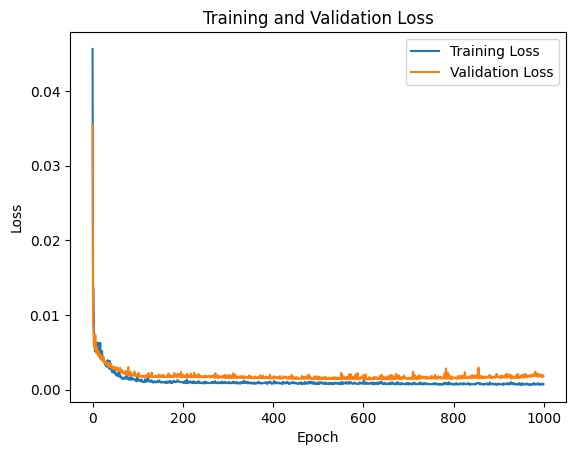

In [9]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", loss)

# Predictions
y_pred = model.predict(X_test)

# Invert scaling for forecast
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate mean squared error
mse = mean_squared_error(y_test_inv, y_pred_inv)
print("Mean Squared Error:", mse)

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

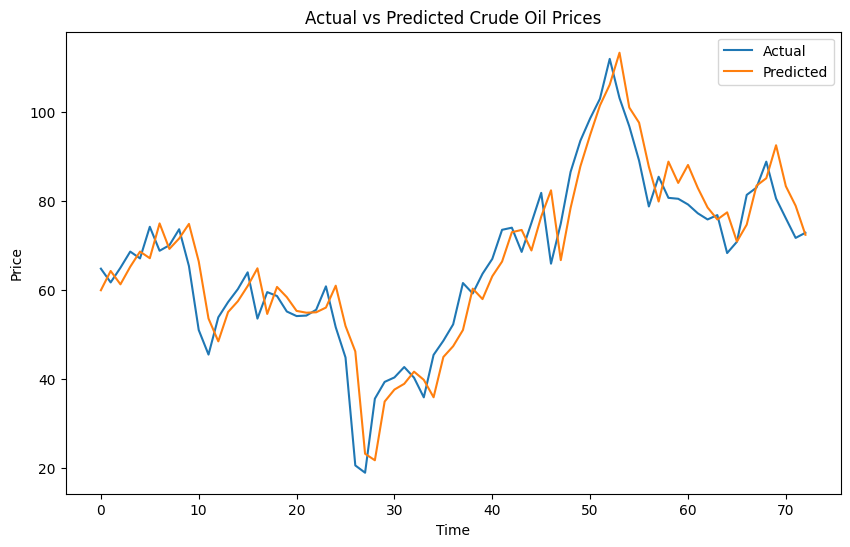

Root Mean Squared Error (RMSE): 7.087493818458662
R-squared (R²) Score: 0.8489791885634169


In [6]:
from sklearn.metrics import r2_score
from math import sqrt

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs Predicted Crude Oil Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse = sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R²
r2 = r2_score(y_test_inv, y_pred_inv)
print("R-squared (R²) Score:", r2)


In [4]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 0.04331661391299751
